# **Note: To use the same paths without any updates, you can upload the unzipped folder to your goodle drive account**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
#Path to the main directory
folder_path = '/content/gdrive/My Drive/FinalProject_LakshyanaKC_NhatPham/Data/'
data_path = folder_path + "fulldata_processed.pickle"

In [ ]:
import pandas as pd
import numpy as np
import re
import json
import time
from datetime import datetime
import pickle
import os
import matplotlib.pyplot as plt
import requests
import itertools
#from sklearn.model_selection import train_test_split
#from sklearn.feature_extraction.text import CountVectorizer
#from sklearn.feature_extraction.text import TfidfTransformer
#from sklearn.naive_bayes import MultinomialNB
#run Random Forest before resampling data
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support as sk_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler


In [ ]:
def now(phrase):
    print(f"[{datetime.now()}]: {phrase}")
    
now("Success!")
def load(filename):
    now("starting")
    if (os.path.exists(filename)):
        with open(filename, 'rb') as f:
            data = pickle.load(f)
        now("ending")
        return data
    else:
        raise FileNotFoundError(f"could not find {filename}")

## saves as pickle object
def save(filename, obj):
    now("Starting")
    with open(filename, 'wb') as f:
        pickle.dump(obj, f)
        print(f"Saved obj Object to {filename}!")
    now("Ending")
    return ''

[2022-05-04 13:34:26.644445]: Success!


In [ ]:
data = load(data_path)
data['RatingId'] = data.RatingId.astype(str)

[2022-05-04 13:34:28.571231]: starting
[2022-05-04 13:34:32.249063]: ending


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 269294 entries, 0 to 522431
Data columns (total 24 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   RecipeId                    269294 non-null  int64  
 1   Name                        269294 non-null  object 
 2   CookTime                    269294 non-null  float64
 3   PrepTime                    269294 non-null  float64
 4   TotalTime                   269294 non-null  float64
 5   Description                 269294 non-null  int64  
 6   Images                      269294 non-null  int64  
 7   RecipeCategory              269049 non-null  object 
 8   Keywords                    269294 non-null  object 
 9   RecipeIngredientQuantities  269292 non-null  object 
 10  RecipeIngredientParts       269294 non-null  object 
 11  AggregatedRating            269294 non-null  float64
 12  ReviewCount                 269294 non-null  float64
 13  Calories      

In [ ]:
print("Proportion of 1, 2-star ratings is ", round((4475*100/269294),2), "% of all observations")

Proportion of 1, 2-star ratings is  1.66 % of all observations


In [ ]:
def identity_tokenizer(text):
    return text

In [ ]:
def train_test_model(model, X_train, X_test, y_train, y_test,labels=None):
    """ Train and test the model using the training and test data sets. Return the predictions, accuracy and metric reports. """
    print('Start training...', end='')
    model.fit(X_train, y_train)
    print(X_train.shape)
    print('done!')
    print('Start testing...', end='')
    predictions = model.predict(X_test)
    accuracy = model.score(X_test, y_test)
    metrics_report = classification_report(y_test, predictions)#, target_names=labels)
    precision, recall, fscore, train_support = sk_score(y_test, predictions, average='weighted')
    print('done!')
    return predictions, metrics_report, (accuracy, precision, recall, fscore)

In [ ]:
def plot_cm(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=False):

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(6, 4))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=0)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [ ]:
labels = data.RatingId.unique()
labels

array(['4', '3', '2', '5'], dtype=object)

In [ ]:
vectorizer1 = TfidfVectorizer(tokenizer=identity_tokenizer,min_df=5,lowercase=False, use_idf=True)
vectorizer2 = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2')

# **Model 1. Instructions only - LinearSVC, RF, LogReg, MultinomialNB**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2')

X = tfidf.fit_transform(data.RecipeInstructions)
y = data.RatingId
X.shape

(269294, 10798)

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 0)

In [ ]:
X_train.shape

(201970, 10798)

In [ ]:
labels = data.RatingId.unique()

Number of documents = 201970  |  Number of features = 10798
Start training...(201970, 10798)
done!
Start testing...

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

done!
Total time: 163.29s
              precision    recall  f1-score   support

           2       0.00      0.00      0.00      1206
           3       0.00      0.00      0.00      3249
           4       0.41      0.04      0.07     19394
           5       0.65      0.98      0.78     43475

    accuracy                           0.64     67324
   macro avg       0.26      0.25      0.21     67324
weighted avg       0.54      0.64      0.53     67324



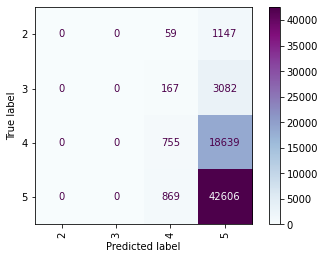

In [ ]:
log_model = LogisticRegression(penalty='l2', max_iter=500, class_weight='balanced')
print('Number of documents = {}  |  Number of features = {}'.format(X_train.shape[0], X_train.shape[1]))
st_time = time.time()
predictions, metrics_report, log_prf = train_test_model(log_model, X_train, X_test, y_train, y_test)
en_time = time.time()
print('Total time: {:.2f}s'.format(en_time-st_time))
print('='*100)
print(metrics_report)
plot_confusion_matrix(log_model, X_test, y_test, xticks_rotation='vertical', cmap="BuPu")

In [ ]:
log_inst = log_prf

(0.6440645237953776,
 0.5377785699273352,
 0.6440645237953776,
 0.5255405727577117)

Number of documents = 201970  |  Number of features = 10798
Start training...(201970, 10798)
done!
Start testing...

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

done!
Total time: 309.43s
              precision    recall  f1-score   support

           2       0.00      0.00      0.00      1206
           3       0.00      0.00      0.00      3249
           4       0.44      0.01      0.01     19394
           5       0.65      1.00      0.78     43475

    accuracy                           0.65     67324
   macro avg       0.27      0.25      0.20     67324
weighted avg       0.54      0.65      0.51     67324



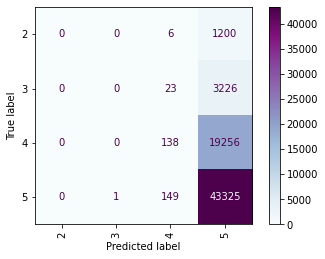

In [ ]:
rf_model = RandomForestClassifier(n_estimators=100, max_depth=100, min_samples_split=10, n_jobs=-1, verbose=0, class_weight='balanced')
print('Number of documents = {}  |  Number of features = {}'.format(X_train.shape[0], X_train.shape[1]))
st_time = time.time()
predictions, metrics_report, rf_prf = train_test_model(rf_model, X_train, X_test, y_train, y_test)
en_time = time.time()
print('Total time: {:.2f}s'.format(en_time-st_time))
print('='*100)
print(metrics_report)
plot_confusion_matrix(rf_model, X_test, y_test, xticks_rotation='vertical', cmap="BuPu")

In [ ]:
rf_inst = rf_prf

Number of documents = 201970  |  Number of features = 10798
Start training...(201970, 10798)
done!
Start testing...done!
Total time: 22.38s
              precision    recall  f1-score   support

           2       0.04      0.12      0.05      1206
           3       0.09      0.06      0.07      3249
           4       0.38      0.15      0.21     19394
           5       0.67      0.83      0.74     43475

    accuracy                           0.58     67324
   macro avg       0.29      0.29      0.27     67324
weighted avg       0.55      0.58      0.55     67324



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


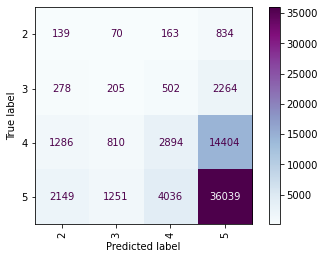

In [ ]:
svm = LinearSVC(class_weight='balanced', verbose=False, max_iter=10000, tol=1e-4, C=0.1)
print('Number of documents = {}  |  Number of features = {}'.format(X_train.shape[0], X_train.shape[1]))
st_time = time.time()
predictions, metrics_report, svm_prf = train_test_model(svm, X_train, X_test, y_train, y_test)
en_time = time.time()
print('Total time: {:.2f}s'.format(en_time-st_time))
print('='*100)
print(metrics_report)
plot_confusion_matrix(svm, X_test, y_test, xticks_rotation='vertical', cmap="BuPu")

In [ ]:
svm_inst = svm_prf
svm_inst

(0.5834026498722595,
 0.5493138401019625,
 0.5834026498722595,
 0.5460716061508453)

Number of documents = 201970  |  Number of features = 10798
Start training...(201970, 10798)
done!
Start testing...done!
Total time: 2.54s
              precision    recall  f1-score   support

           2       0.00      0.00      0.00      1206
           3       0.00      0.00      0.00      3249
           4       0.38      0.00      0.01     19394
           5       0.65      1.00      0.78     43475

    accuracy                           0.64     67324
   macro avg       0.26      0.25      0.20     67324
weighted avg       0.53      0.64      0.51     67324



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


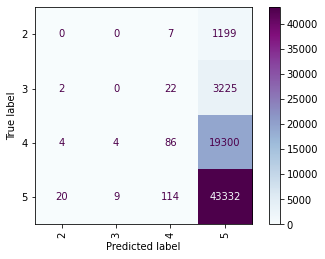

In [ ]:
nb_model = MultinomialNB()
print('Number of documents = {}  |  Number of features = {}'.format(X_train.shape[0], X_train.shape[1]))
st_time = time.time()
predictions, metrics_report, nb_prf = train_test_model(nb_model, X_train, X_test, y_train, y_test)
en_time = time.time()
print('Total time: {:.2f}s'.format(en_time-st_time))
print('='*100)
print(metrics_report)
plot_confusion_matrix(nb_model, X_test, y_test, xticks_rotation='vertical', cmap="BuPu")

In [ ]:
nb_inst = nb_prf

# **Model 2. 3 text features - LinearSVC, RF, LogReg, MultinomialNB**


In [ ]:
X = data[['RecipeIngredientParts', 
        'RecipeInstructions',
        'Keywords']]
y = data['RatingId']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 3)

In [ ]:
text1 = 'RecipeIngredientParts'
text2 = 'Keywords'
text3 = 'RecipeInstructions'

preprocessor = ColumnTransformer([
    ('text1', vectorizer1,text1),
    ('text2', vectorizer1,text2),
    ('text3', vectorizer2,text3)
])
preprocessor.fit(X_train)

ColumnTransformer(transformers=[('text1',
                                 TfidfVectorizer(lowercase=False, min_df=5,
                                                 tokenizer=<function identity_tokenizer at 0x7f085d98b680>),
                                 'RecipeIngredientParts'),
                                ('text2',
                                 TfidfVectorizer(lowercase=False, min_df=5,
                                                 tokenizer=<function identity_tokenizer at 0x7f085d98b680>),
                                 'Keywords'),
                                ('text3',
                                 TfidfVectorizer(min_df=5, sublinear_tf=True),
                                 'RecipeInstructions')])

In [ ]:
X_train.shape

(201970, 3)

In [ ]:
rf_model = RandomForestClassifier(n_estimators=100, max_depth=100, min_samples_split=10, n_jobs=-1, verbose=0, class_weight='balanced')

pipe = Pipeline([('preprocessor', preprocessor),('model', rf_model)])

print('Number of documents = {}  |  Number of features = {}'.format(X_train.shape[0], X_train.shape[1]))
st_time = time.time()
predictions, metrics_report, rf_prf = train_test_model(pipe, X_train, X_test, y_train, y_test, labels)

en_time = time.time()
print('Total time: {:.2f}s'.format(en_time-st_time))
print('='*100)
print(metrics_report)

cm = confusion_matrix(y_test, predictions,labels=['2','3','4','5'])
plot_cm(cm,['2','3','4','5'],title='Confusion Matrix')

Number of documents = 201970  |  Number of features = 3
Start training...

KeyboardInterrupt: ignored

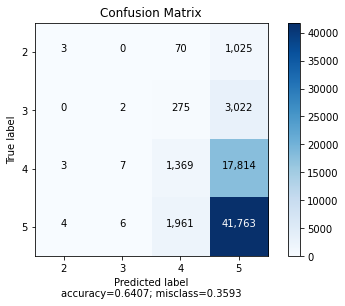

In [ ]:
rf_text = rf_prf

Number of documents = 201970  |  Number of features = 3
Start training...

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


(201970, 3)
done!
Start testing...done!
Total time: 210.19s
              precision    recall  f1-score   support

           2       0.02      0.22      0.04      1098
           3       0.06      0.27      0.10      3299
           4       0.32      0.28      0.30     19193
           5       0.72      0.41      0.52     43734

    accuracy                           0.36     67324
   macro avg       0.28      0.29      0.24     67324
weighted avg       0.56      0.36      0.43     67324



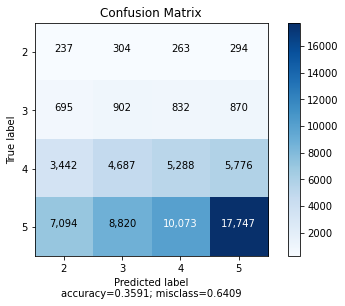

In [ ]:
log_model = LogisticRegression(penalty='l2', max_iter=500, class_weight='balanced')
pipe = Pipeline([('preprocessor', preprocessor),('model', log_model)])

print('Number of documents = {}  |  Number of features = {}'.format(X_train.shape[0], X_train.shape[1]))
st_time = time.time()
predictions, metrics_report, log_prf = train_test_model(pipe, X_train, X_test, y_train, y_test, labels)

en_time = time.time()
print('Total time: {:.2f}s'.format(en_time-st_time))
print('='*100)
print(metrics_report)
cm = confusion_matrix(y_test, predictions,labels=['2','3','4','5'])
plot_cm(cm,['2','3','4','5'],title='Confusion Matrix')

In [ ]:
log_text = log_prf

Number of documents = 201970  |  Number of features = 3
Start training...

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


(201970, 3)
done!
Start testing...done!
Total time: 210.27s
              precision    recall  f1-score   support

           2       0.02      0.22      0.04      1098
           3       0.06      0.27      0.10      3299
           4       0.32      0.28      0.30     19193
           5       0.72      0.41      0.52     43734

    accuracy                           0.36     67324
   macro avg       0.28      0.29      0.24     67324
weighted avg       0.56      0.36      0.43     67324



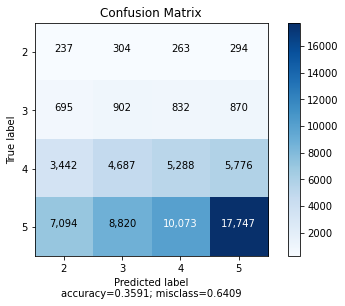

In [ ]:
nb_model = MultinomialNB()
pipe = Pipeline([('preprocessor', preprocessor),('model', nb_model)])

print('Number of documents = {}  |  Number of features = {}'.format(X_train.shape[0], X_train.shape[1]))
st_time = time.time()
predictions, metrics_report, nb_prf = train_test_model(pipe, X_train, X_test, y_train, y_test, labels)

en_time = time.time()
print('Total time: {:.2f}s'.format(en_time-st_time))
print('='*100)
print(metrics_report)
cm = confusion_matrix(y_test, predictions,labels=['2','3','4','5'])
plot_cm(cm,['2','3','4','5'],title='Confusion Matrix')

In [ ]:
nb_text = nb_prf

# **Model 3. Instructions + Ingredients**



In [ ]:
X = data[['RecipeIngredientParts', 
        'RecipeInstructions']]
y = data['RatingId']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 3)

In [ ]:
text1 = 'RecipeIngredientParts'
text2 = 'RecipeInstructions'

preprocessor = ColumnTransformer([
    ('text1', vectorizer1,text1),
    ('text2', vectorizer2,text2)])
preprocessor.fit(X_train)

ColumnTransformer(transformers=[('text1',
                                 TfidfVectorizer(lowercase=False, min_df=5,
                                                 tokenizer=<function identity_tokenizer at 0x7f3370b53710>),
                                 'RecipeIngredientParts'),
                                ('text2',
                                 TfidfVectorizer(min_df=5, sublinear_tf=True),
                                 'RecipeInstructions')])

Number of documents = 201970  |  Number of features = 2
Start training...(201970, 2)
done!
Start testing...done!
Total time: 277.20s
              precision    recall  f1-score   support

           2       0.25      0.00      0.01      1098
           3       0.14      0.00      0.00      3299
           4       0.37      0.08      0.13     19193
           5       0.66      0.95      0.78     43734

    accuracy                           0.64     67324
   macro avg       0.35      0.26      0.23     67324
weighted avg       0.54      0.64      0.54     67324



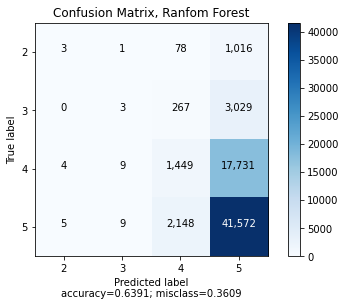

In [ ]:
rf_model = RandomForestClassifier(n_estimators=100, max_depth=100, min_samples_split=10, n_jobs=-1, verbose=0,class_weight='balanced')

pipe = Pipeline([('preprocessor', preprocessor),('model', rf_model)])

print('Number of documents = {}  |  Number of features = {}'.format(X_train.shape[0], X_train.shape[1]))
st_time = time.time()
predictions, metrics_report, rf_prf = train_test_model(pipe, X_train, X_test, y_train, y_test, labels)

en_time = time.time()
print('Total time: {:.2f}s'.format(en_time-st_time))
print('='*100)
print(metrics_report)
cm = confusion_matrix(y_test, predictions,labels=['2','3','4','5'])
plot_cm(cm,['2','3','4','5'],title='Confusion Matrix, Ranfom Forest')

In [ ]:
rf_2 = rf_prf

Number of documents = 201970  |  Number of features = 2
Start training...

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


(201970, 2)
done!
Start testing...done!
Total time: 203.66s
              precision    recall  f1-score   support

           2       0.02      0.21      0.04      1098
           3       0.06      0.27      0.10      3299
           4       0.32      0.27      0.29     19193
           5       0.71      0.40      0.51     43734

    accuracy                           0.35     67324
   macro avg       0.28      0.29      0.23     67324
weighted avg       0.56      0.35      0.42     67324



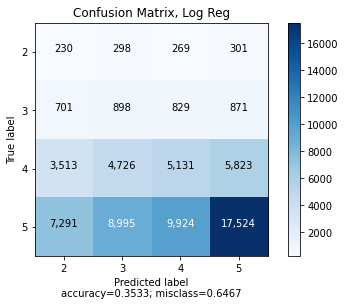

In [ ]:
log_model = LogisticRegression(penalty='l2', max_iter=500, class_weight='balanced')
pipe = Pipeline([('preprocessor', preprocessor),('model', log_model)])

print('Number of documents = {}  |  Number of features = {}'.format(X_train.shape[0], X_train.shape[1]))
st_time = time.time()
predictions, metrics_report, log_prf = train_test_model(pipe, X_train, X_test, y_train, y_test, labels)

en_time = time.time()
print('Total time: {:.2f}s'.format(en_time-st_time))
print('='*100)
print(metrics_report)
cm = confusion_matrix(y_test, predictions,labels=['2','3','4','5'])
plot_cm(cm,['2','3','4','5'],title='Confusion Matrix, Log Reg')

In [ ]:
log_2 = log_prf

Number of documents = 201970  |  Number of features = 2
Start training...

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


(201970, 2)
done!
Start testing...done!
Total time: 204.45s
              precision    recall  f1-score   support

           2       0.02      0.21      0.04      1098
           3       0.06      0.27      0.10      3299
           4       0.32      0.27      0.29     19193
           5       0.71      0.40      0.51     43734

    accuracy                           0.35     67324
   macro avg       0.28      0.29      0.23     67324
weighted avg       0.56      0.35      0.42     67324



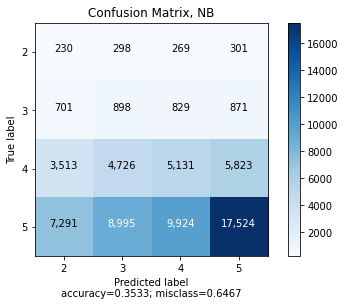

In [ ]:
nb_model = MultinomialNB()
pipe = Pipeline([('preprocessor', preprocessor),('model', log_model)])

print('Number of documents = {}  |  Number of features = {}'.format(X_train.shape[0], X_train.shape[1]))
st_time = time.time()
predictions, metrics_report, nb_prf = train_test_model(pipe, X_train, X_test, y_train, y_test, labels)

en_time = time.time()
print('Total time: {:.2f}s'.format(en_time-st_time))
print('='*100)
print(metrics_report)
cm = confusion_matrix(y_test, predictions,labels=['2','3','4','5'])
plot_cm(cm,['2','3','4','5'],title='Confusion Matrix, NB')

In [ ]:
nb_2 = nb_prf

Number of documents = 201970  |  Number of features = 2
Start training...(201970, 2)
done!
Start testing...done!
Total time: 47.13s
              precision    recall  f1-score   support

           2       0.03      0.12      0.04      1098
           3       0.07      0.08      0.08      3299
           4       0.37      0.16      0.23     19193
           5       0.68      0.78      0.73     43734

    accuracy                           0.56     67324
   macro avg       0.29      0.29      0.27     67324
weighted avg       0.55      0.56      0.54     67324



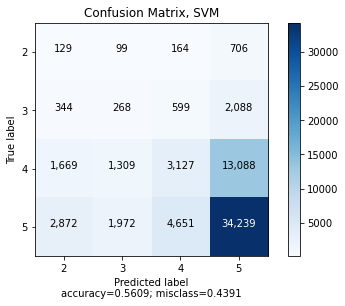

In [ ]:
svm = LinearSVC(class_weight='balanced', verbose=False, max_iter=10000, tol=1e-4, C=0.1)
pipe = Pipeline([('preprocessor', preprocessor),('model', svm)])

print('Number of documents = {}  |  Number of features = {}'.format(X_train.shape[0], X_train.shape[1]))
st_time = time.time()
predictions, metrics_report, svm_prf = train_test_model(pipe, X_train, X_test, y_train, y_test, labels)

en_time = time.time()
print('Total time: {:.2f}s'.format(en_time-st_time))
print('='*100)
print(metrics_report)
cm = confusion_matrix(y_test, predictions,labels=['2','3','4','5'])
plot_cm(cm,['2','3','4','5'],title='Confusion Matrix, SVM')

In [ ]:
svm_2 = svm_prf

# **Model 4. Text + numeric features - LinearSVC, RF, LogReg, MultinomialNB**

In [ ]:
# Set X and y
df=data.copy()
X = df[['RecipeIngredientParts', 
        'RecipeInstructions',
        'Keywords',
        'Calories',
        'TotalTime',
        'PrepTime',
        'Description',
        'Images',
        'FatContent',
        'SaturatedFatContent',
        'CholesterolContent',
        'SodiumContent',
        'CarbohydrateContent',
        'FiberContent',
        'SugarContent',
        'ProteinContent']]
y = df['RatingId']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 3)

In [ ]:
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
])
numerical = ['Calories',
        'TotalTime',
        'PrepTime',
        'Description',
        'Images',
        'FatContent',
        'SaturatedFatContent',
        'CholesterolContent',
        'SodiumContent',
        'CarbohydrateContent',
        'FiberContent',
        'SugarContent',
        'ProteinContent']
text1 = 'RecipeIngredientParts'
text2 = 'Keywords'
text3 = 'RecipeInstructions'

preprocessor = ColumnTransformer([
    ('num', num_pipe, numerical),
    ('text1', vectorizer1,text1),
    ('text2', vectorizer1,text2),
    ('text3', vectorizer2,text3)
])
preprocessor.fit(X_train)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', MinMaxScaler())]),
                                 ['Calories', 'TotalTime', 'PrepTime',
                                  'Description', 'Images', 'FatContent',
                                  'SaturatedFatContent', 'CholesterolContent',
                                  'SodiumContent', 'CarbohydrateContent',
                                  'FiberContent', 'SugarContent',
                                  'ProteinContent']),
                                ('text1',
                                 TfidfVectorizer(lowercase=False, min_df=5,
                                                 tokenizer=<function identity_tokenizer at 0x7f085d98b680>),
                                 'RecipeIngredientParts'),
                                

Number of documents = 201970  |  Number of features = 16
Start training...(201970, 16)
done!
Start testing...done!
Total time: 328.37s
              precision    recall  f1-score   support

           2       0.60      0.00      0.01      1098
           3       0.00      0.00      0.00      3299
           4       0.38      0.07      0.11     19193
           5       0.66      0.96      0.78     43734

    accuracy                           0.64     67324
   macro avg       0.41      0.26      0.22     67324
weighted avg       0.55      0.64      0.54     67324



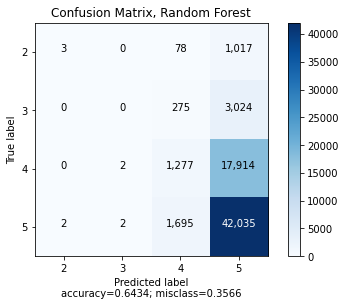

In [ ]:
rf_model = RandomForestClassifier(n_estimators=100, max_depth=100, min_samples_split=10, n_jobs=-1, verbose=0, class_weight='balanced')

pipe = Pipeline([('preprocessor', preprocessor),('model', rf_model)])

print('Number of documents = {}  |  Number of features = {}'.format(X_train.shape[0], X_train.shape[1]))
st_time = time.time()
predictions, metrics_report, rf_prf = train_test_model(pipe, X_train, X_test, y_train, y_test, labels)

en_time = time.time()
print('Total time: {:.2f}s'.format(en_time-st_time))
print('='*100)
print(metrics_report)
cm = confusion_matrix(y_test, predictions,labels=['2','3','4','5'])
plot_cm(cm,['2','3','4','5'],title='Confusion Matrix, Random Forest')

In [ ]:
rf_all = rf_prf

Number of documents = 201970  |  Number of features = 16
Start training...

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


(201970, 16)
done!
Start testing...done!
Total time: 225.64s
              precision    recall  f1-score   support

           2       0.02      0.23      0.04      1098
           3       0.07      0.28      0.11      3299
           4       0.32      0.28      0.30     19193
           5       0.73      0.42      0.54     43734

    accuracy                           0.37     67324
   macro avg       0.29      0.30      0.25     67324
weighted avg       0.57      0.37      0.44     67324



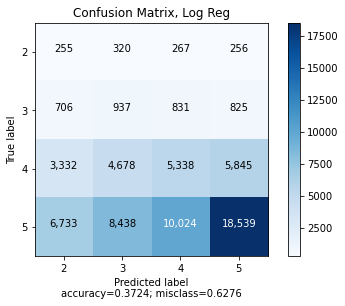

In [ ]:
log_model = LogisticRegression(penalty='l2', max_iter=500, class_weight='balanced')
pipe = Pipeline([('preprocessor', preprocessor),('model', log_model)])

print('Number of documents = {}  |  Number of features = {}'.format(X_train.shape[0], X_train.shape[1]))
st_time = time.time()
predictions, metrics_report, log_prf = train_test_model(pipe, X_train, X_test, y_train, y_test, labels)

en_time = time.time()
print('Total time: {:.2f}s'.format(en_time-st_time))
print('='*100)
print(metrics_report)
cm = confusion_matrix(y_test, predictions,labels=['2','3','4','5'])
plot_cm(cm,['2','3','4','5'],title='Confusion Matrix, Log Reg')

In [ ]:
log_all = log_prf

Number of documents = 201970  |  Number of features = 16
Start training...(201970, 16)
done!
Start testing...done!
Total time: 24.72s
              precision    recall  f1-score   support

           2       0.09      0.00      0.01      1098
           3       0.00      0.00      0.00      3299
           4       0.39      0.12      0.19     19193
           5       0.66      0.93      0.77     43734

    accuracy                           0.64     67324
   macro avg       0.29      0.26      0.24     67324
weighted avg       0.54      0.64      0.56     67324



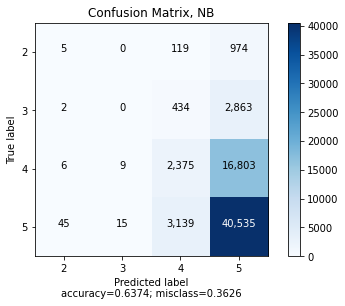

In [ ]:
nb_model = MultinomialNB()
pipe = Pipeline([('preprocessor', preprocessor),('model', nb_model)])

print('Number of documents = {}  |  Number of features = {}'.format(X_train.shape[0], X_train.shape[1]))
st_time = time.time()
predictions, metrics_report, nb_prf = train_test_model(pipe, X_train, X_test, y_train, y_test, labels)

en_time = time.time()
print('Total time: {:.2f}s'.format(en_time-st_time))
print('='*100)
print(metrics_report)
cm = confusion_matrix(y_test, predictions,labels=['2','3','4','5'])
plot_cm(cm,['2','3','4','5'],title='Confusion Matrix, NB')

In [ ]:
nb_all = nb_prf

Number of documents = 201970  |  Number of features = 16
Start training...(201970, 16)
done!
Start testing...done!
Total time: 55.78s
              precision    recall  f1-score   support

           2       0.03      0.13      0.05      1098
           3       0.08      0.09      0.09      3299
           4       0.37      0.17      0.24     19193
           5       0.69      0.78      0.73     43734

    accuracy                           0.56     67324
   macro avg       0.29      0.29      0.27     67324
weighted avg       0.56      0.56      0.55     67324



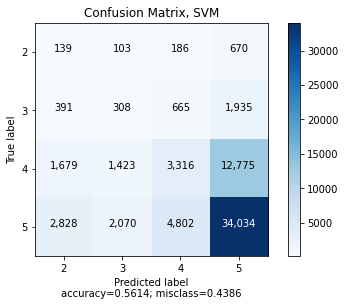

In [ ]:
svm = LinearSVC(class_weight='balanced', verbose=False, max_iter=10000, tol=1e-4, C=0.1)
pipe = Pipeline([('preprocessor', preprocessor),('model', svm)])

print('Number of documents = {}  |  Number of features = {}'.format(X_train.shape[0], X_train.shape[1]))
st_time = time.time()
predictions, metrics_report, svm_prf = train_test_model(pipe, X_train, X_test, y_train, y_test, labels)

en_time = time.time()
print('Total time: {:.2f}s'.format(en_time-st_time))
print('='*100)
print(metrics_report)
cm = confusion_matrix(y_test, predictions,labels=['2','3','4','5'])
plot_cm(cm,['2','3','4','5'],title='Confusion Matrix, SVM')


In [ ]:
svm_all = svm_prf

# **Model 5. Model 4 + balanced data**

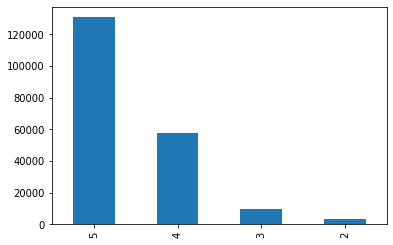

In [ ]:
count = y_train.value_counts()
count.plot.bar()

In [ ]:
n_samples = int(count.median())
n_samples

33905

In [ ]:
y_train.shape

(201970,)

In [ ]:
from imblearn.over_sampling import RandomOverSampler 

# transform the dataset
strategy = {'2':57765, '3':57765}
oversample = RandomOverSampler(sampling_strategy=strategy)
oversample
X_over, y_over = oversample.fit_resample(X_train, y_train)

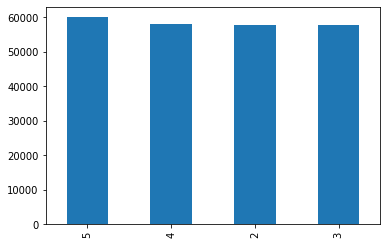

In [ ]:
from imblearn.under_sampling import RandomUnderSampler 

# transform the dataset
strategy = {'5':60000}
undersample = RandomUnderSampler(sampling_strategy=strategy)
X_bal, y_bal = undersample.fit_resample(X_over, y_over)
count = y_bal.value_counts()
count.plot.bar()

In [ ]:
print(X_bal.shape)
print(X_train.shape)
print(y_bal.shape)
print(y_train.shape)

(233496, 16)
(201970, 16)
(233496,)
(201970,)


Number of documents = 233496  |  Number of features = 16
Start training...(233496, 16)
done!
Start testing...done!
Total time: 792.85s
              precision    recall  f1-score   support

           2       0.18      0.00      0.00      1098
           3       0.27      0.00      0.00      3299
           4       0.33      0.51      0.40     19193
           5       0.70      0.59      0.64     43734

    accuracy                           0.53     67324
   macro avg       0.37      0.28      0.26     67324
weighted avg       0.56      0.53      0.53     67324



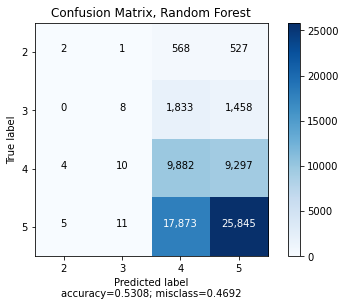

In [ ]:
preprocessor.fit(X_bal)

rf_model = RandomForestClassifier(n_estimators=100, max_depth=100, min_samples_split=10, n_jobs=-1, verbose=0, class_weight='balanced')

pipe = Pipeline([('preprocessor', preprocessor),('model', rf_model)])

print('Number of documents = {}  |  Number of features = {}'.format(X_bal.shape[0], X_bal.shape[1]))
st_time = time.time()
predictions, metrics_report, rf_prf = train_test_model(pipe, X_bal, X_test, y_bal, y_test, labels)

en_time = time.time()
print('Total time: {:.2f}s'.format(en_time-st_time))
print('='*100)
print(metrics_report)
cm = confusion_matrix(y_test, predictions,labels=['2','3','4','5'])
plot_cm(cm,['2','3','4','5'],title='Confusion Matrix, Random Forest')


In [ ]:
rf_bal = rf_prf

Number of documents = 233496  |  Number of features = 16
Start training...

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


(233496, 16)
done!
Start testing...done!
Total time: 254.48s
              precision    recall  f1-score   support

           2       0.02      0.22      0.04      1098
           3       0.07      0.28      0.11      3299
           4       0.32      0.30      0.31     19193
           5       0.73      0.43      0.54     43734

    accuracy                           0.38     67324
   macro avg       0.29      0.31      0.25     67324
weighted avg       0.57      0.38      0.44     67324



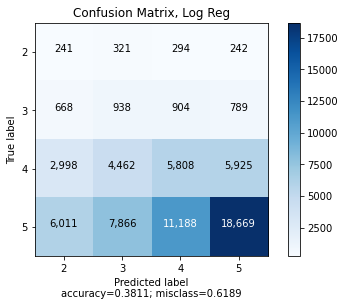

In [ ]:
log_model = LogisticRegression(penalty='l2', max_iter=500, class_weight='balanced')
pipe = Pipeline([('preprocessor', preprocessor),('model', log_model)])

print('Number of documents = {}  |  Number of features = {}'.format(X_bal.shape[0], X_bal.shape[1]))
st_time = time.time()
predictions, metrics_report, log_prf = train_test_model(pipe, X_bal, X_test, y_bal, y_test, labels)

en_time = time.time()
print('Total time: {:.2f}s'.format(en_time-st_time))
print('='*100)
print(metrics_report)
cm = confusion_matrix(y_test, predictions,labels=['2','3','4','5'])
plot_cm(cm,['2','3','4','5'],title='Confusion Matrix, Log Reg')

In [ ]:
log_bal = log_prf

Number of documents = 233496  |  Number of features = 16
Start training...(233496, 16)
done!
Start testing...done!
Total time: 27.11s
              precision    recall  f1-score   support

           2       0.03      0.36      0.05      1098
           3       0.06      0.10      0.07      3299
           4       0.33      0.42      0.37     19193
           5       0.72      0.37      0.49     43734

    accuracy                           0.37     67324
   macro avg       0.28      0.31      0.25     67324
weighted avg       0.57      0.37      0.43     67324



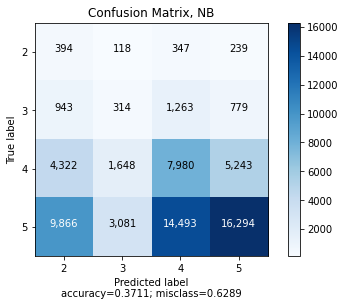

In [ ]:
nb_model = MultinomialNB()
pipe = Pipeline([('preprocessor', preprocessor),('model', nb_model)])

print('Number of documents = {}  |  Number of features = {}'.format(X_bal.shape[0], X_bal.shape[1]))
st_time = time.time()
predictions, metrics_report, nb_prf = train_test_model(pipe, X_bal, X_test, y_bal, y_test, labels)

en_time = time.time()
print('Total time: {:.2f}s'.format(en_time-st_time))
print('='*100)
print(metrics_report)
cm = confusion_matrix(y_test, predictions,labels=['2','3','4','5'])
plot_cm(cm,['2','3','4','5'],title='Confusion Matrix, NB')

In [ ]:
nb_bal = nb_prf

Number of documents = 233496  |  Number of features = 16
Start training...(233496, 16)
done!
Start testing...done!
Total time: 43.59s
              precision    recall  f1-score   support

           2       0.02      0.26      0.04      1098
           3       0.07      0.28      0.11      3299
           4       0.33      0.25      0.28     19193
           5       0.73      0.44      0.55     43734

    accuracy                           0.38     67324
   macro avg       0.29      0.31      0.24     67324
weighted avg       0.57      0.38      0.44     67324



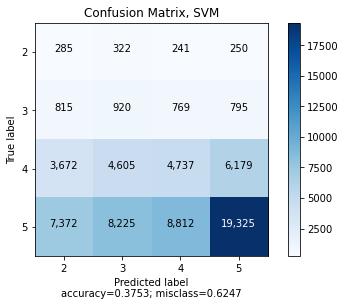

In [ ]:
svm = LinearSVC(class_weight='balanced', verbose=False, max_iter=10000, tol=1e-4, C=0.1)
pipe = Pipeline([('preprocessor', preprocessor),('model', svm)])
print('Number of documents = {}  |  Number of features = {}'.format(X_bal.shape[0], X_bal.shape[1]))
st_time = time.time()
predictions, metrics_report, svm_prf = train_test_model(pipe, X_bal, X_test, y_bal, y_test)
en_time = time.time()
print('Total time: {:.2f}s'.format(en_time-st_time))
print('='*100)
print(metrics_report)
cm = confusion_matrix(y_test, predictions,labels=['2','3','4','5'])
plot_cm(cm,['2','3','4','5'],title='Confusion Matrix, SVM')


In [ ]:
svm_bal = svm_prf

# **Performance comparison**

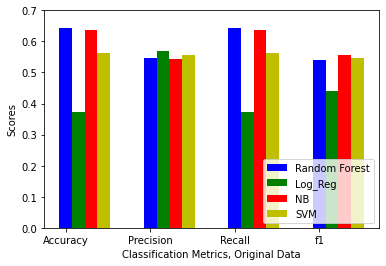

In [ ]:
xx = np.array([1,2,3,4])
width = 0.15
gb_prf = np.array([0.83, 0.83, 0.83,0.83])
ax = plt.subplot(111)
ax.bar(xx - width, height=np.array(rf_all), width=width, color='b', align='center', label='Random Forest', tick_label=['Accuracy','Precision', 'Recall', 'f1'])
ax.bar(xx ,height=np.array(log_all), width=width, color='g', align='center', label='Log_Reg')
ax.bar(xx + width, height=np.array(nb_all), width=width, color='r', align='center', label='NB')
ax.bar(xx + 2*width, height=np.array(svm_all), width=width, color='y', align='center', label='SVM')


plt.xlabel('Classification Metrics, Original Data')
plt.ylabel('Scores')
plt.legend(loc='lower right')
plt.ylim([0, 0.7])
plt.show()

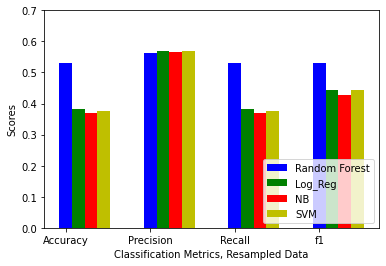

In [ ]:
xx = np.array([1,2,3,4])
width = 0.15
gb_prf = np.array([0.83, 0.83, 0.83,0.83])
ax = plt.subplot(111)
ax.bar(xx - width, height=np.array(rf_bal), width=width, color='b', align='center', label='Random Forest', tick_label=['Accuracy','Precision', 'Recall', 'f1'])
ax.bar(xx ,height=np.array(log_bal), width=width, color='g', align='center', label='Log_Reg')
ax.bar(xx + width, height=np.array(nb_bal), width=width, color='r', align='center', label='NB')
ax.bar(xx + 2*width, height=np.array(svm_bal), width=width, color='y', align='center', label='SVM')

plt.xlabel('Classification Metrics, Resampled Data')
plt.ylabel('Scores')
plt.legend(loc='lower right')
plt.ylim([0, 0.7])
plt.show()